In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

def get_excluded_features():
    df = pd.read_csv('CodeBook-SELECT.csv')
    excluded = []

    for i in range(0, 377):
        desc = df.iloc[i]['Description']
        varname = df.iloc[i]['VarName']

        if 'ISCO' in desc or 'ISCO' in varname:
            excluded.append(varname)

        elif 'ISIC' in desc or 'ISIC' in varname:
            excluded.append(varname)

        elif 'mth' in desc or 'mth' in varname:
            excluded.append(varname)

        elif 'coded' in desc or 'coded' in varname:
            excluded.append(varname)

    return excluded

In [2]:
def get_included_numeric_columns(df):
    # Find numeric columns
    num_col = []
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            num_col.append(col)

    print('NUM COL')
    print(len(num_col))

    incl_num_cols = []
    for col in num_col:
        noise = [9996, 9997, 9998, 9999, 996, 997, 998, 999]
        df[col] = df[col].replace(noise, np.nan)
                
        if df[col].isna().sum() < 10000:
            m = df[col].mean()
            if m > 1990.0 and m < 2020.0:
                df[col] = df[col] - 1990.0
            incl_num_cols.append(col)
#             if m >= 1.0:
#                 if not (m > 9000.0 and m < 10000.0):
#                     incl_num_cols.append(col)

#                     if m > 1990.0 and m < 2020.0:
#                         df[col] = df[col] - 1990.0
                        
#     df[incl_num_cols] = df[incl_num_cols].fillna(df.median().iloc[0])
    df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].median().iloc[0])
#     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mean().iloc[0])
    print('ASU 1')
    print(df[incl_num_cols].isnull().values.any())
#     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mode())

    print('INCL COL')
    print(len(incl_num_cols))

    return df, incl_num_cols

In [3]:
def one_hot_encode(df, col_names):
    print(len(col_names))

    iter = 0
    new_cols = []
    for col in col_names:
        if( df[col].dtype == np.dtype('object')):
            if len(df[col].unique()) < 3:
                df[col] = df[col].astype('category')
                df[col] = df[col].cat.codes
                new_cols.append(col)
            else:
                dummies = pd.get_dummies(df[col],prefix=col)
                new_cols = new_cols + dummies.columns.tolist()
                df = pd.concat([df,dummies],axis=1)
                #drop the encoded column
                df.drop([col],axis = 1 , inplace=True)

            iter = iter + 1
            if (iter % 100 == 0):
                print(iter)

    return df, new_cols

In [4]:
def get_included_cat_cols(df, incl_num_cols):
    # TODO: Remove 999?

    cat_col = list(set(df.columns).difference(set(incl_num_cols)))

    print('CAT COL')
    print(len(cat_col))

    incl_cat_cols = []
    for col in cat_col:
        noise = ['9996', '9997', '9998', '9999', '996', '997', '998', '999']
        df[col] = df[col].replace(noise, np.nan)
        
#         incl_cat_cols.append(col)
        
        # INI PENTING BGT, KALO NGK JADI MINUS 900 MEANNYA WKWK
        if 'v' in col and col != 'vet' and len(col) < 5:
            if len(df[col].unique()) < 51:
                incl_cat_cols.append(col)
        else:
            incl_cat_cols.append(col)
#         incl_cat_cols.append(col)
    # for col in cat_col:
    #     if len(df[col].unique()) < 11:
    #             incl_cat_cols.append(col)
    #     incl_cat_cols.append(col)
    
#     df[incl_cat_cols] = df[incl_cat_cols].fillna(df.mode().iloc[0])
    df[incl_cat_cols] = df[incl_cat_cols].fillna(df[incl_cat_cols].mode().iloc[0])

    print('INCL COL')
    print(len(incl_num_cols))

    print('There were {} columns before encoding categorical features'.format(df.shape[1]))
    df, incl_cat_cols = one_hot_encode(df, incl_cat_cols)
    print('There are {} columns after encoding categorical features'.format(df.shape[1]))

    return df, incl_cat_cols

In [5]:
def prepare_train(df, incl_num_cols, incl_cat_cols):
    # Drop 40% of the males to obtain balance
#     sampling_percentage = 0
    sampling_percentage = 30
#     dropped_indexes = df[df['gender_r_Male'] == 1].sample(frac=float(sampling_percentage/100), random_state = 28).index
    dropped_indexes = df[df['gender_r'] == 1].sample(frac=float(sampling_percentage/100), random_state = 28).index
#     dropped_indexes = df[df['gender_r'] == 1].sample(frac=float(sampling_percentage/100), random_state = 0).index

    with open('dropped_indexes_' + str(sampling_percentage) + '.pickle', 'wb') as outfile:
        # dump information to that file
        pickle.dump(dropped_indexes, outfile)

    train_df = df.drop(dropped_indexes)
    print(len(train_df))
    print(len(train_df.columns))
    train_df = train_df[incl_num_cols + incl_cat_cols]

    df = df[incl_num_cols + incl_cat_cols]
    print(len(df))
    print(len(df.columns))

    return df, train_df


In [6]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
    
def train_and_eval(df, train_df):
    X_train = train_df.drop(['job_performance'], axis=1).values
    y_train = train_df['job_performance'].values

    # from sklearn.model_selection import GridSearchCV
    # # Create the parameter grid based on the results of random search
    # param_grid = {
    #     'bootstrap': [True],
    #     'max_depth': [10, 20],
    #     'max_features': ['auto'],
    #     'min_samples_leaf': [50, 100],
    #     'min_samples_split': [100, 200],
    #     'n_estimators': [20, 50]
    # }
    # # Create a based model
    # rf = RandomForestRegressor(random_state = 40)
    # # Instantiate the grid search model
    # grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    # grid_search.fit(X_train, y_train)
    
    # Create the parameter grid based on the results of random search
#     param_grid = {
#         'alpha': [0.1, 0.2, 0.5, 1.0]
#     }
#     # Create a based model
#     rf = linear_model.Lasso(random_state = 28)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2)
#     grid_search.fit(X_train, y_train)

#     print(grid_search.best_params_)
#     clf = grid_search.best_estimator_
    
    # can be any estimator that has attribute 'feature_importances_' or 'coef_'
#     model = RandomForestRegressor(random_state=28) 

#     model.fit(X_train, y_train)

#     fs = SelectFromModel(model, prefit=True)

#     X_train_new = fs.transform(X_train) # columns selected
    
#     print(len(X_train_new[0]))
#     print(X_train_new.columns)

    # Train the model using the training sets
#     clf = RandomForestRegressor(max_depth = 20, min_samples_leaf = 25, min_samples_split = 50, n_estimators = 100, random_state = 28)
#     clf = linear_model.LinearRegression()
#     clf = linear_model.Lasso(alpha=1.0, max_iter=1000)
    clf = linear_model.Lasso(alpha=0.1, max_iter=1000)
#     clf = linear_model.Ridge(alpha=1.0)
#     clf = linear_model.Ridge(alpha=1.0)
    # {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50}
#     print(clf.get_params())
#     clf = linear_model.LinearRegression()
#     scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
#     scores = cross_validate(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
#     print(scores)
    
#     clf.fit(X_train_new, y_train)
    clf.fit(X_train, y_train)

#     X_train = fs.transform(df.drop(['job_performance'], axis=1).values)
    X_train = df.drop(['job_performance'], axis=1).values
    y_train = df['job_performance'].values

    y_pred = clf.predict(X_train)

    print('Mean: ' + str(np.mean(y_pred)))
    print('Median: ' + str(np.median(y_pred)))
    print('Variance: ' + str(np.var(y_pred)))

    return clf, y_pred, mean_squared_error(y_train, y_pred)

In [7]:
def main_1(model_name):
    df = pd.read_csv('hw4-trainingset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    df, train_df = prepare_train(df, incl_num_cols, incl_cat_cols)

    clf, df['y_pred'], mse = train_and_eval(df, train_df)

    print('MSE: ' + str(mse))

    with open(model_name, 'wb') as outfile:
        pickle.dump(clf, outfile)

    return df

In [8]:
# main_1('apa')

In [9]:
def main_2(model_name, train_cols):
    df = pd.read_csv('hw4-testset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    for missing_col in list(set(train_cols).difference(set(df.columns))):
        df[missing_col] = np.zeros(24500, dtype='int')

    df = df[train_cols]
    
#     for gajelas in ['v272', 'v52', 'v135']:
#         df[gajelas] = np.zeros(24500, dtype='int')

    X_test = df.drop(['job_performance'], axis=1).values
    print(np.where(np.isnan(X_test)))
    
    for idx in set(np.where(np.isnan(X_test))[1]):
        X_test[:, idx] = np.zeros(24500, dtype='int')

    with open(model_name, 'rb') as infile:
        clf = pickle.load(infile)

    df['job_performance'] = clf.predict(X_test)

    print('Mean: ' + str(np.mean(df['job_performance'])))
    print('Median: ' + str(np.median(df['job_performance'])))
    print('Variance: ' + str(np.var(df['job_performance'])))

    return df, X_test

In [10]:
# main_2('test_model.pickle', [])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60
ASU 1
False
INCL COL
24
CAT COL
319
INCL COL
24
There were 343 columns before encoding categorical features
311
100
200
There are 1332 columns after encoding categorical features
16252
1332
20000
1295


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466088973.3334029, tolerance: 297943.75225902273
  positive)


Mean: 2911.2212290473253
Median: 2936.140424117242
Variance: 106095.14437744873
MSE: 75569.59116725833


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f70588>]],
      dtype=object)

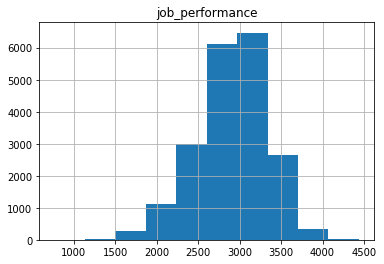

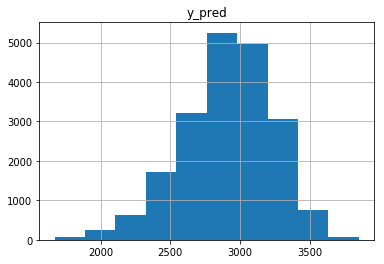

In [11]:
x = main_1('test_model.pickle')
# print('NUMS')
#     print(set(x).difference(set(a)))
# print('----')
# print(set(a).difference(set(x)))
# print('----')
#
# print('CATS')
# print(set(y).difference(set(b)))
# print('----')
# print(set(b).difference(set(y)))
# print('----')

%matplotlib inline
x.hist(column='job_performance')
x.hist(column='y_pred')
# len(x[x['gender_r'] == 1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1230db320>]],
      dtype=object)

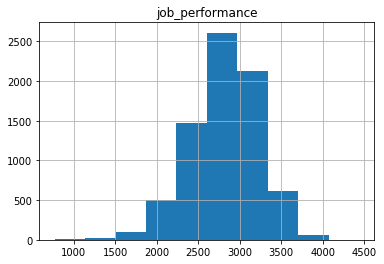

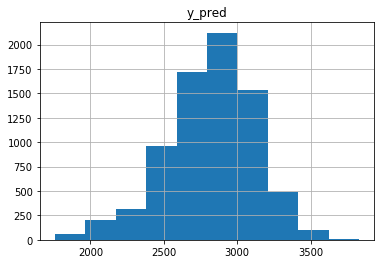

In [12]:
# x[x['gender_r_Male'] == 0].hist(column='job_performance')
# x[x['gender_r_Male'] == 0].hist(column='y_pred')
x[x['gender_r'] == 0].hist(column='job_performance')
x[x['gender_r'] == 0].hist(column='y_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123c7ba20>]],
      dtype=object)

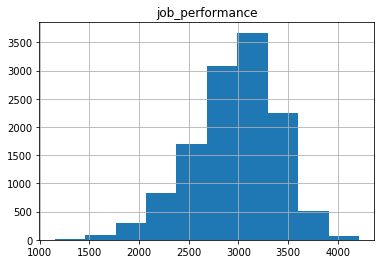

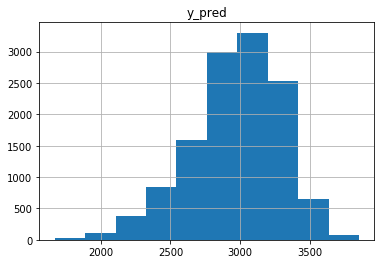

In [13]:
# x[x['gender_r_Male'] == 1].hist(column='job_performance')
# x[x['gender_r_Male'] == 1].hist(column='y_pred')
x[x['gender_r'] == 1].hist(column='job_performance')
x[x['gender_r'] == 1].hist(column='y_pred')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,260,268) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60
ASU 1
False
INCL COL
15
CAT COL
328
INCL COL
15
There were 343 columns before encoding categorical features
311
100
200
There are 1353 columns after encoding categorical features
(array([    1,     2,     3, ..., 24497, 24498, 24498]), array([22, 19, 19, ..., 22, 19, 22]))
Mean: 2796.033038190632
Median: 2812.4071532516664
Variance: 189617.75230757296


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1234742b0>]],
      dtype=object)

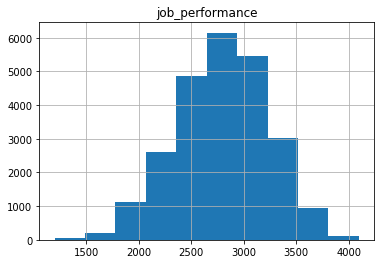

In [14]:
%matplotlib inline
a_df, a_x_test = main_2('test_model.pickle', x.drop(['y_pred'], axis=1).columns)
a_df.hist('job_performance')

In [15]:
# print(a_df.columns[[19,20,22]])
# a_x_test[:, 22]
# print(np.count_nonzero(~np.isnan(a_x_test[:, 19])))
# print(np.count_nonzero(~np.isnan(a_x_test[:, 20])))
# print(np.count_nonzero(~np.isnan(a_x_test[:, 2])))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f700b8>]],
      dtype=object)

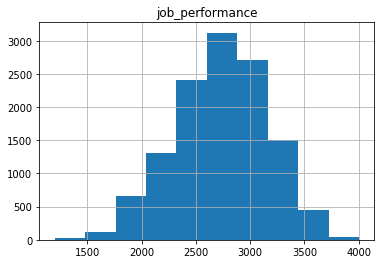

In [16]:
# a_df[a_df['gender_r_Male'] == 0].hist(column='job_performance')
a_df[a_df['gender_r'] == 0].hist(column='job_performance')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123073358>]],
      dtype=object)

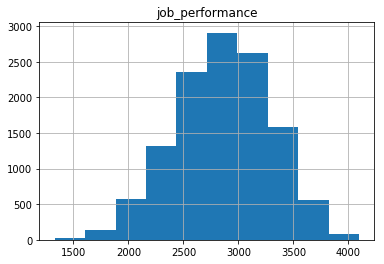

In [17]:
# a_df[a_df['gender_r_Male'] == 1].hist(column='job_performance')
a_df[a_df['gender_r'] == 1].hist(column='job_performance')

In [18]:
# TODO: MEDIAN and SCALER
# kalo bisa regression bgs
# Insight: LASSO BETTER MEAN alpha 0.1 bgs dr 0.25

# LINREG FIX CORET, MEAN KECIL 1700
# RIDGE 0.5 JG SAMA 2100
# RIDGE 1.0 2300

In [19]:
len(a_df[a_df['job_performance'] <= 3200]) / 24500

0.8177142857142857

In [20]:
len(x[x['job_performance'] <= 3400]) / 20000

0.88695

In [21]:
dropped_indexes = x[x['gender_r'] == 1].sample(frac=float(40/100), random_state = 28).index
y = x.drop(dropped_indexes)
print(len(y[y['job_performance'] <= 3000]) / len(y))
print(y['job_performance'].var())

0.5679909345420611
182790.30950866255


In [22]:
len(x[x['y_pred'] <= 3200]) / 20000

0.80725

In [23]:
# len(a_df[a_df['job_performance'] <= 1500]['gender_r_Female'])
print(np.sum(a_df[a_df['job_performance'] <= 1500]['gender_r']))
print(len(a_df[a_df['job_performance'] <= 1500]['gender_r']))
# print(a_df[a_df['job_performance'] <= 1500]).index

13
43


In [24]:
# len(x[x['job_performance'] <= 1500]['gender_r_Female'])
# len(x[x['job_performance'] <= 1500]['gender_r'])
dropped_indexes = x[x['gender_r'] == 1].sample(frac=float(40/100), random_state = 28).index
y = x.drop(dropped_indexes)
print(len(y[y['job_performance'] <= 3200]) / len(y))

print(x['job_performance'].mean())
print(x['job_performance'].median())
print(x['job_performance'].var())

print(y['job_performance'].mean())
print(y['job_performance'].median())
print(y['job_performance'].var())

print(len(y))
print(len(y[y['gender_r'] == 0]))
print(len(y[y['gender_r'] == 1]))

0.7568324223436875
2909.9065328638526
2942.4136951062956
183187.6856396561
2891.638857793095
2922.96407013043
182790.30950866255
15002
7505
7497


In [25]:
df = pd.read_csv('hw4-trainingset-gd2551.csv')
df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
# num_col = []
# for col in df.columns:
#     if np.issubdtype(df[col].dtype, np.number):
#         num_col.append(col)

# print('NUM COL')
# print(len(num_col))

In [27]:
# df[num_col].isna().sum()

In [28]:
print('Mean train: ' + str(df['job_performance'].mean()))
print('Median train: ' + str(df['job_performance'].median()))
print('Mean male: ' + str(df[df['gender_r'] == 'Male']['job_performance'].mean()))
print('Median male: ' + str(df[df['gender_r'] == 'Male']['job_performance'].median()))
print('Mean female: ' + str(df[df['gender_r'] == 'Female']['job_performance'].mean()))
print('Median female: ' + str(df[df['gender_r'] == 'Female']['job_performance'].median()))

Mean train: 2909.9065328638526
Median train: 2942.4136951062956
Mean male: 2966.0717037520453
Median male: 3012.53908781253
Mean female: 2816.3976973877757
Median female: 2841.2000023565197


In [29]:
dropped_indexes = df[df['gender_r'] == 'Male'].sample(frac=float(40/100), random_state = 28).index
st_df = df.drop(dropped_indexes)
print('Mean train: ' + str(st_df['job_performance'].mean()))
print('Median train: ' + str(st_df['job_performance'].median()))
print('Mean male: ' + str(st_df[st_df['gender_r'] == 'Male']['job_performance'].mean()))
print('Median male: ' + str(st_df[st_df['gender_r'] == 'Male']['job_performance'].median()))
print('Mean female: ' + str(st_df[st_df['gender_r'] == 'Female']['job_performance'].mean()))
print('Median female: ' + str(st_df[st_df['gender_r'] == 'Female']['job_performance'].median()))

Mean train: 2891.638857793095
Median train: 2922.96407013043
Mean male: 2966.960307551921
Median male: 3018.96069131828
Mean female: 2816.3976973877757
Median female: 2841.2000023565197


In [30]:
print('Mean train: ' + str(x['y_pred'].mean()))
print('Median train: ' + str(x['y_pred'].median()))
print('Mean male: ' + str(x[x['gender_r'] == 1]['y_pred'].mean()))
print('Median male: ' + str(x[x['gender_r'] == 1]['y_pred'].median()))
print('Mean female: ' + str(x[x['gender_r'] == 0]['y_pred'].mean()))
print('Median female: ' + str(x[x['gender_r'] == 0]['y_pred'].median()))

Mean train: 2911.2212290473253
Median train: 2936.140424117242
Mean male: 2968.0459993358227
Median male: 2998.466016402564
Mean female: 2816.614233077333
Median female: 2843.8576430217468


In [31]:
print('Mean train: ' + str(a_df['job_performance'].mean()))
print('Median train: ' + str(a_df['job_performance'].median()))
print('Mean male: ' + str(a_df[a_df['gender_r'] == 1]['job_performance'].mean()))
print('Median male: ' + str(a_df[a_df['gender_r'] == 1]['job_performance'].median()))
print('Mean female: ' + str(a_df[a_df['gender_r'] == 0]['job_performance'].mean()))
print('Median female: ' + str(a_df[a_df['gender_r'] == 0]['job_performance'].median()))

# MEAN NYA RENDAH BGT KALO GA DI SAMPLING JADI 2000 BAWAH

Mean train: 2796.033038190632
Median train: 2812.4071532516664
Mean male: 2858.3502724596187
Median male: 2876.4467217092224
Mean female: 2734.574655143837
Median female: 2754.2658709552425


In [32]:
# df['job_performance'].var()

In [33]:
# print(df['nfehrs'].max())
# print(df[df['nfehrs'] >= 1000.0]['nfehrs'])

In [34]:
# print(df['v63'].mean())
# print(df[df['v63'] >= 1000.0]['v63'])

In [35]:
# # Submission
final_df = pd.read_csv('hw4-testset-gd2551.csv')
final_df['job_performance'] = a_df['job_performance']
final_df.to_csv(index=False, path_or_buf='test_submission_v2.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (50,172,255,256,257,258,260,268) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
import pandas as pd
a = pd.read_csv('hw4-trainingset-gd2551.csv')
len(a[a['job_performance'] < 2200]) / 20000

0.0637